In [1]:
import xarray as xr
import pandas as pd
import numpy as np

env_data = xr.open_dataset("../data/lgm_env/Tierney2020_DA_ocn_regrid.nc")
SST_LGM = env_data['SSTLGM']
SST_HOL = env_data['SSTLH']
SSS_LGM = env_data['SSSLGM']
SSS_HOL = env_data['SSSLH']

Had_data = xr.open_dataset("../data/modern_env/HadISST_sst.nc")
Had_SST = Had_data['sst']

# mask sea-ice-covered gridboxes (i.e., -1000)
Had_SST = xr.where(Had_SST==-1000, np.nan, Had_SST)

# mask Land squares are set to -32768
Had_SST = xr.where(Had_SST==-32768, np.nan, Had_SST)

# pick 1870 year (SST)
Had_SST = Had_SST.isel(time=0)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


/Users/yingrui/miniforge3/envs/workspace/lib/python3.10/site-packages/xarray/coding/variables.py:142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


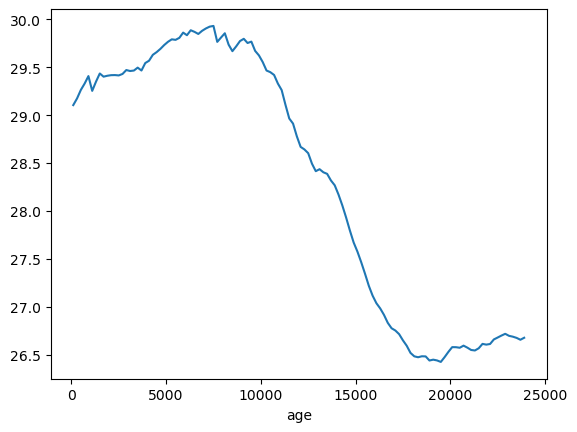

In [26]:
import xarray as xr
import numpy as np

#deglacial sst
deg_sst = xr.open_dataset("../data/deglaciation_climate/LGMR_SST_climo.nc", drop_variables=['lon','lat'])
#250-300
#300-360, 0-40
#deg_sst['sst'].sel(age=11000, method="nearest").plot()
mask = (
        (deg_sst["lat"] > 200)
        & (deg_sst["lat"] < 350)
        & (deg_sst["lon"] > 0)
        & (deg_sst["lon"] < 40)
)
xr.where(mask, np.nan, deg_sst['sst']).max(axis=0).max(axis=0).plot()


In [2]:
def convert2_pos_lon(x):
    "from -180~180 to 0~360"
    x[x<0] = x[x<0] + 360
    return x

def add_tierney_sst(data, lookup_data = SST_LGM, column_name="SST"):
    lst = []
    latitude = data['Latitude'].copy()
    longitude = data['Longitude'].copy()
    longitude = convert2_pos_lon(longitude)

    for i in range(len(longitude)):
        lat = latitude[i]
        lon = longitude[i]
        x = lookup_data.sel(lat=lat,
                         lon=lon,
                         method="nearest",
                         tolerance=1).values

        if np.isnan(x):
            x = lookup_data.sel(lat=lat,
                             lon=lon,
                             method="pad").values
        if np.isnan(x):
            x = lookup_data.sel(lat=lat,
                             lon=lon,
                             method="backfill").values
        lst.append(x)
    data[column_name] = np.array(lst)

def add_Had_data(data, lookup_data = Had_SST, column_name="SST"):
    lst = []
    latitude = data['Latitude'].copy()
    longitude = data['Longitude'].copy()

    for i in range(len(longitude)):
        lat = latitude[i]
        lon = longitude[i]
        x = lookup_data.sel(latitude=lat,
                         longitude=lon,
                         tolerance=1,
                         method="nearest").values
        lst.append(x)
    data[column_name] = np.array(lst)

In [7]:
lgm_pacific = pd.read_csv("../data/lgm_foram/raw/LGM_MARGO/LGM_MARGO_pacific_count.csv")
lgm_atlantic = pd.read_csv("../data/lgm_foram/raw/LGM_MARGO/LGM_MARGO_SouthAtlantic_count.csv")
climap_lgm = pd.read_csv("../data/lgm_foram/raw/LGM_CLIMAP.csv")

add_tierney_sst(lgm_pacific, SST_LGM, "SST")
add_tierney_sst(lgm_atlantic, SST_LGM, "SST")
add_tierney_sst(climap_lgm, SST_LGM, "SST")

add_tierney_sst(lgm_pacific, SSS_LGM, "SSS")
add_tierney_sst(lgm_atlantic, SSS_LGM, "SSS")
add_tierney_sst(climap_lgm, SSS_LGM, "SSS")

lgm_pacific.to_csv("../data/lgm_foram/raw/LGM_MARGO/LGM_MARGO_pacific_count_wsst.csv",index=False)
lgm_atlantic.to_csv("../data/lgm_foram/raw/LGM_MARGO/LGM_MARGO_SouthAtlantic_count_wsst.csv",index=False)
climap_lgm.to_csv("../data/lgm_foram/raw/LGM_CLIMAP_wsst.csv",index=False)

In [4]:
forcens = pd.read_csv("../data/modern_foram/raw/forcens_raw_count.csv")
forcens = forcens.dropna(subset=['Longitude', 'Latitude'])
forcens = forcens.reset_index(drop=True)
add_tierney_sst(forcens, SST_HOL, "SST")
add_tierney_sst(forcens, SSS_HOL, "SSS")
forcens.to_csv("../data/modern_foram/raw/forcens_raw_count_wsst.csv")